# Imports and data

In [1]:


import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache2")
# set_global("cache_dir", "/Users/ahemf/mygit/facebook-hateful-memes/cache")
set_global("dataloader_workers", 32)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask, dict2sampleList, run_simclr, load_stored_params
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, HalfSwap, get_transforms_for_bbox_methods
from facebook_hateful_memes_detector.preprocessing import get_transforms_for_multiview
from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset, ImageFolderDataset, ZipDatasets
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel
from facebook_hateful_memes_detector.models.MultiModal import VilBertVisualBertModelV2, MLMSimCLR, MLMOnlyV2, make_plots
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
from facebook_hateful_memes_detector.utils import get_vgg_face_model, get_torchvision_classification_models, init_fc, my_collate, merge_sample_lists
reload(facebook_hateful_memes_detector)

devices = ["cuda:0", "cuda:0", "cuda:1", "cuda:2", "cuda:3",]
# devices = ["cpu"] * 5
device = torch.device(devices[0] if torch.cuda.is_available() else "cpu")
device1 = torch.device(devices[1] if torch.cuda.is_available() else "cpu")
device2 = torch.device(devices[2] if torch.cuda.is_available() else "cpu")
device3 = torch.device(devices[3] if torch.cuda.is_available() else "cpu")
device4 = torch.device(devices[4] if torch.cuda.is_available() else "cpu")

set_device(device)
print(get_device())

scheduler_init_fn = get_cosine_schedule_with_warmup()
scheduler_init_fn = get_constant_schedule_with_warmup()
set_global("gradient_clipping", 10)
# Use mixup in SSL training, Use UDA maybe
# os.path.join(get_global("models_dir"),)


cuda:0


In [2]:
add_objects_and_caption = False
from collections import defaultdict
obcp = pd.read_csv("/home/ahemf/cache/data/objects_captions.csv").values
object_captions = defaultdict(dict)
for d in obcp:
    object_captions[d[0]]["objects"] = d[1]
    object_captions[d[0]]["caption"] = d[2]
    


In [3]:
import random
def get_preprocess_text():
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, 
                 "punctuation_insert": 0.25, "punctuation_continue": 0.5}
    gibberish = TextAugment([0.01, 0.99], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    sentence_level = {"word_masking": 0.5, "part_select": 0.2,}
    sentence_level = TextAugment([0.1, 0.9], sentence_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/hard_dab.csv")
    def process(text, **kwargs):
        text = translation(text, **kwargs)
        text = gibberish(text, **kwargs)
        text = sentence_level(text, **kwargs)
        return text
    return process

preprocess_text = get_preprocess_text()

def get_views():
    image_views = get_transforms_for_multiview()
    def get_view(imv):
        imtrans = image_views[imv]
        ag_idx = imv + 1
        def aug_sample(sample):
            text = preprocess_text(sample.original_text, identifier=sample.id)
            if ag_idx == 3 and add_objects_and_caption:
                text = text + sep + str(object_captions[sample.id]["caption"]) + sep + str(object_captions[sample.id]["objects"])
            sample["text_view_%s" % ag_idx] = text
            sample["image_view_%s" % ag_idx] = imtrans(sample.original_image)
        return aug_sample
    
    return [get_view(0), get_view(1), get_view(2)]

data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=None,
                    train_image_transform=None,
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)





In [4]:
import random
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.4, 0.5], char_level)
    word_level = {"split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "punctuation_continue": 0.5}
    word_level = TextAugment([0.1, 0.4, 0.5], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin")
    sentence_level = {"word_masking": 0.0, # "glove_twitter": 0.75, 
                      "one_third_cut": 0.2, "half_cut":0.0, "part_select": 0.2, }
    sentence_level = TextAugment([0.1, 0.9], sentence_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv"
                                )
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, "punctuation_continue": 0.5}
    gibberish = TextAugment([0.25, 0.75], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/hard_dab.csv")
    def process(text, **kwargs):
        if random.random() < 0.2:
            text = sentence_level(text, **kwargs)
        else:
            text = translation(text, **kwargs)
        text = word_level(text, **kwargs)
        text = char_level(text, **kwargs)
        text = gibberish(text, **kwargs)
        return text
    return process

preprocess_text = get_preprocess_text()
def get_views():
    image_views = get_transforms_for_multiview()
    def get_view(imv):
        
        imtrans = image_views[imv]
        ag_idx = imv + 1
        def aug_sample(sample):
            text = preprocess_text(sample.original_text, identifier=sample.id)
            if ag_idx == 3 and add_objects_and_caption:
                text = text + sep + str(object_captions[sample.id]["caption"]) + sep + str(object_captions[sample.id]["objects"])
            sample["text_view_%s" % ag_idx] = text
            sample["image_view_%s" % ag_idx] = imtrans(sample.original_image)
        return aug_sample
    
    return [get_view(0), get_view(1), get_view(2)]

# transforms.RandomAffine(0, scale=(0.75, 0.75))
# transforms.RandomAffine(0, scale=(1.25, 1.25))
# DefinedRotation(15)

data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=preprocess_text,
                    train_image_transform=get_transforms_for_bbox_methods(),
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)






In [5]:
data["test"]["label"] = -1
data['test_unseen']["label"] = -1
dev_unseen = data['dev_unseen'].copy()
data['dev_unseen']["label"] = -1

df = pd.concat((data["train"],
                data['dev_unseen'],
                data["test"], data['test_unseen']))
df.shape


(12540, 4)

In [6]:

dataset = convert_dataframe_to_dataset(df, data["metadata"], True, additional_processors=get_views())

In [7]:
model_params = dict(
    model_name={"lxmert": dict(dropout=0.1, gaussian_noise=0.02, feature_dropout=0.01), 
                "vilbert": dict(dropout=0.05, gaussian_noise=0.01, feature_dropout=0.01), 
                "visual_bert": dict(dropout=0.05, gaussian_noise=0.01, feature_dropout=0.01),
                "mmbt_region": dict(dropout=0.1, gaussian_noise=0.02, feature_dropout=0.01)},
    num_classes=2,
    gaussian_noise=0.01,
    dropout=0.1,
    word_masking_proba=0.15,
    whole_word_masking=True,
    featurizer="pass",
    final_layer_builder=fb_1d_loss_builder,
    internal_dims=768,
    classifier_dims=768,
    n_tokens_in=96,
    n_tokens_out=96,
    n_layers=0,
    attention_drop_proba=0.0,
    loss="focal",
    dice_loss_coef=0.0,
    auc_loss_coef=0.0,
    bbox_swaps=1,
    bbox_copies=1,
    bbox_deletes=1,
    bbox_gaussian_noise=0.01,
    bbox_feature_dropout=0.01,
    bbox_dropout=0.05,
    view_transforms=get_views(),
    view_loss_weight=0.1,
    devices=dict(lxmert=device1, vilbert=device4, 
                 visual_bert=device3, mmbt_region=device2),
    finetune=False)

model_class = VilBertVisualBertModelV2
model = model_class(**model_params)

del model.vilbert.model.classifier
del model.visual_bert.model.classifier
del model.mmbt_region.model.classifier




Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true


Some weights of the model checkpoint at bert-base-uncased were not used when initializing ViLBERTBase: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing ViLBERTBase from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ViLBERTBase from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViLBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.v_embeddings.image_embeddings.weight', 'bert.v_embeddings.image_embeddings.bias', 'bert.v_embeddings.image_location_embeddings.weight', 'bert.v_embeddings.image_location_embeddings.bias', 'bert.v_embeddings.LayerNorm.weight', 'bert.v_embeddings.LayerNorm.

Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true


Some weights of VisualBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.embeddings.token_type_embeddings_visual.weight', 'bert.embeddings.position_embeddings_visual.weight', 'bert.embeddings.projection.weight', 'bert.embeddings.projection.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Overriding option config to projects/hateful_memes/configs/mmbt/with_features.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to mmbt.hateful_memes.features
Overriding option evaluation.predict to true


Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  768 Matches embedding_dims:  True


In [8]:
# torch.save(model.lxmert.state_dict(), os.path.join(get_global("models_dir"),"lxmert-mlm-init.pth"))
model.lxmert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"lxmert-mlm-init.pth")))

# torch.save(model.mmbt_region.state_dict(), os.path.join(get_global("models_dir"),"mmbt_region-mlm-init.pth"))
model.mmbt_region.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"mmbt_region-mlm-init.pth")))


# torch.save(model.visual_bert.state_dict(), os.path.join(get_global("models_dir"),"visual_bert-mlm-init.pth"))
model.visual_bert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"visual_bert-mlm-init.pth")))

# torch.save(model.vilbert.state_dict(), os.path.join(get_global("models_dir"),"vilbert-mlm-init.pth"))
model.vilbert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"vilbert-mlm-init.pth")))




<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

# Unimodal MLM

In [8]:
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBertV2 import positive, negative
mlm_model = MLMOnlyV2(model, 0.1, {1: negative, 0: positive}, None, mlm_loss_weight=1.0,)
# mlm_model = mlm_model.to(get_device())
# mlm_model.load_state_dict(torch.load("mlm-model-v2.pth"))
mlm_model.load_state_dict(torch.load("mlm-model-v2-view-1.pth"))
# mlm_model = mlm_model.to(get_device())


<All keys matched successfully>

In [9]:
# torch.save(mlm_model.state_dict(), "mlm-model-v2-view-1.pth")



In [ ]:

lr_strategy = {
    "finetune": True,
    "model": {
        "vilbert": {"finetune": True,},
        "visual_bert": {"finetune": True,},
        "mmbt_region": {"finetune": True,},
        "lxmert": {"finetune": True,},
    },
    "mlm": {"finetune": True},
}
epochs = 2
batch_size = 8
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=2e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
# optimizer_params = dict(lr=2e-5, momentum=0.9, weight_decay=1e-3, nesterov=True)

_ = group_wise_finetune(mlm_model, lr_strategy)
params_conf, _ = group_wise_lr(mlm_model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates, _ = train(mlm_model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=8, plot=True,
                                     sampling_policy=None, class_weights=None)




Autocast =  True Epochs =  2 Divisor = 1 Examples = 12540 Batch Size =  8
Training Samples =  12540 Weighted Sampling =  False Num Batches =  1568 Accumulation steps =  8


Exception for:  keyboard | [Original Text]: put'?n the "??ham" [Final Text]: put'?n the "??ham" 
[Augs]: ['keyboard' 'char_insert'] argument of type 'NoneType' is not iterable


In [12]:
clean_memory()


In [13]:
cache_stats = get_global("cache_stats")
cache_stats['get_img_details']
cache_stats['get_lxmert_details']

train_stats = get_global("train_stats")
train_stats


defaultdict(float,
            {'called': 72824.0,
             'hit': 72820.0,
             'read_time': 0.0021804401101783648,
             'key_error': 4.0,
             'read-return-none': 4.0,
             'compute': 4.0,
             'writes': 4.0,
             'write_time': 0.005163576412200928})

defaultdict(float,
            {'called': 72816.0,
             'hit': 72812.0,
             'read_time': 0.0019255347330729663,
             'key_error': 4.0,
             'read-return-none': 4.0,
             'compute': 4.0,
             'writes': 4.0,
             'write_time': 0.003933997035026551})

defaultdict(float,
            {'batch_time': 0.11403452895549038,
             'model_time': 13.365981079730652})

In [ ]:
model_parameters = list(filter(lambda p: p.requires_grad, model.lxmert.parameters()))
params = sum([np.prod(p.size()) for p in model_parameters])
print("Trainable Params = %s" % (params), "\n", model.lxmert)


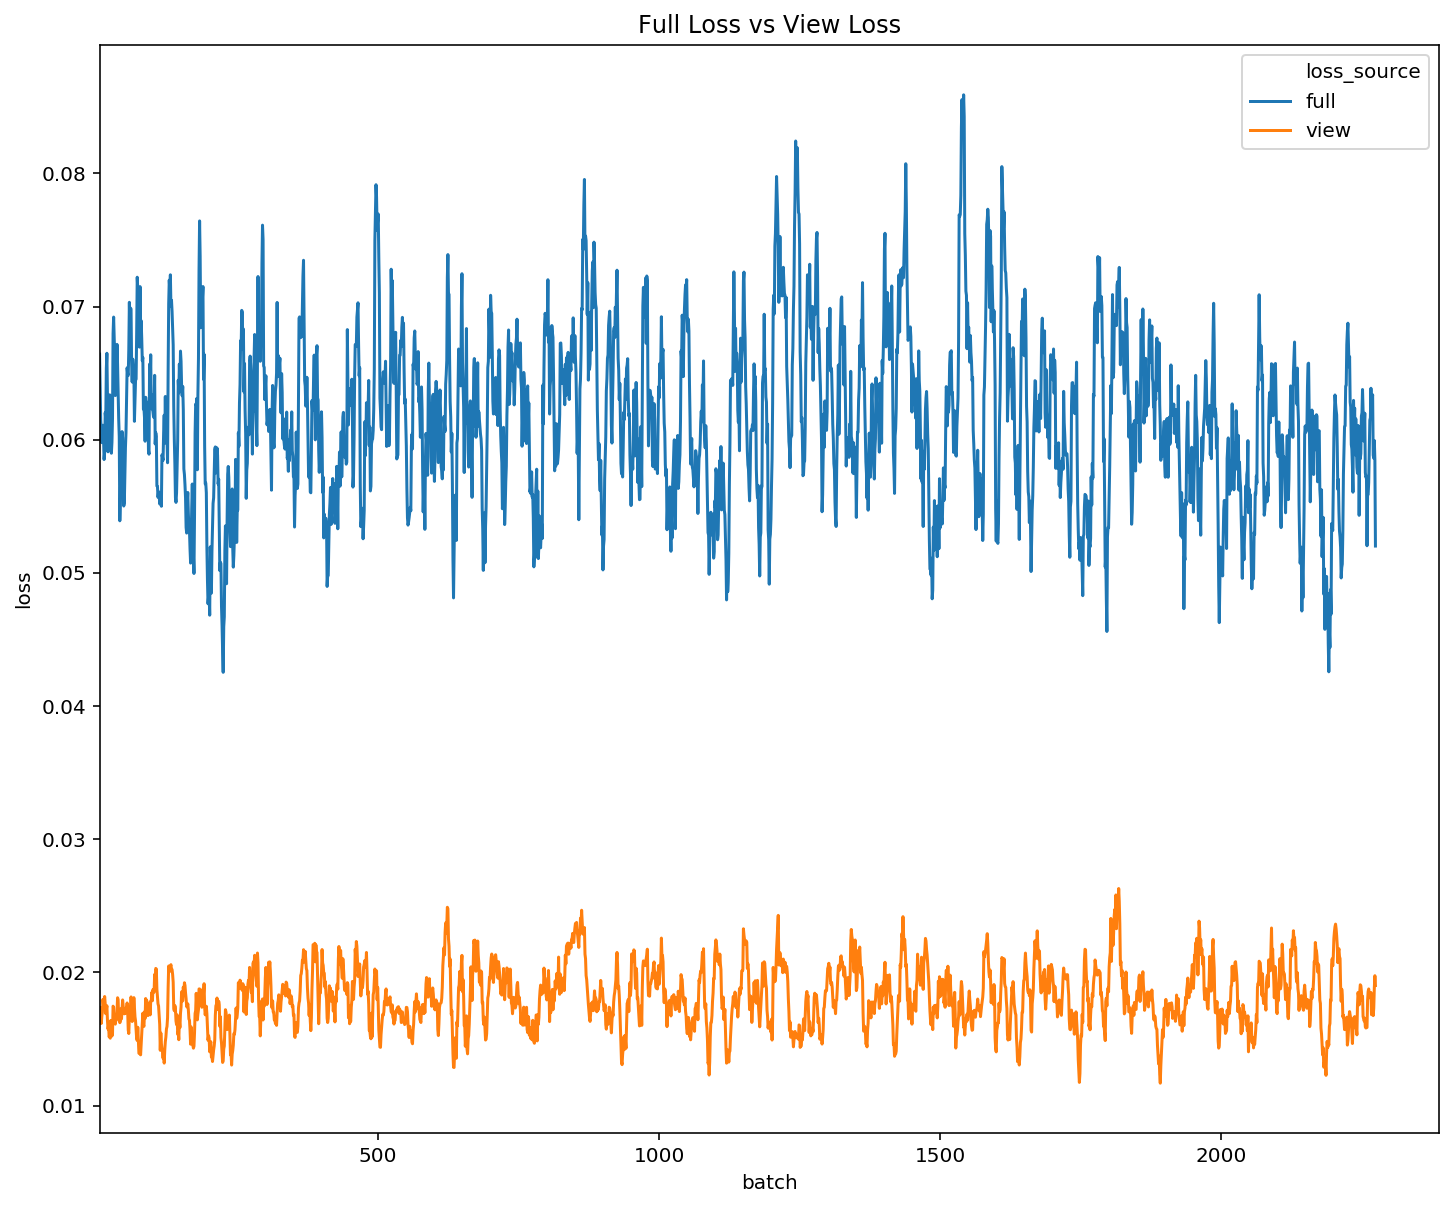

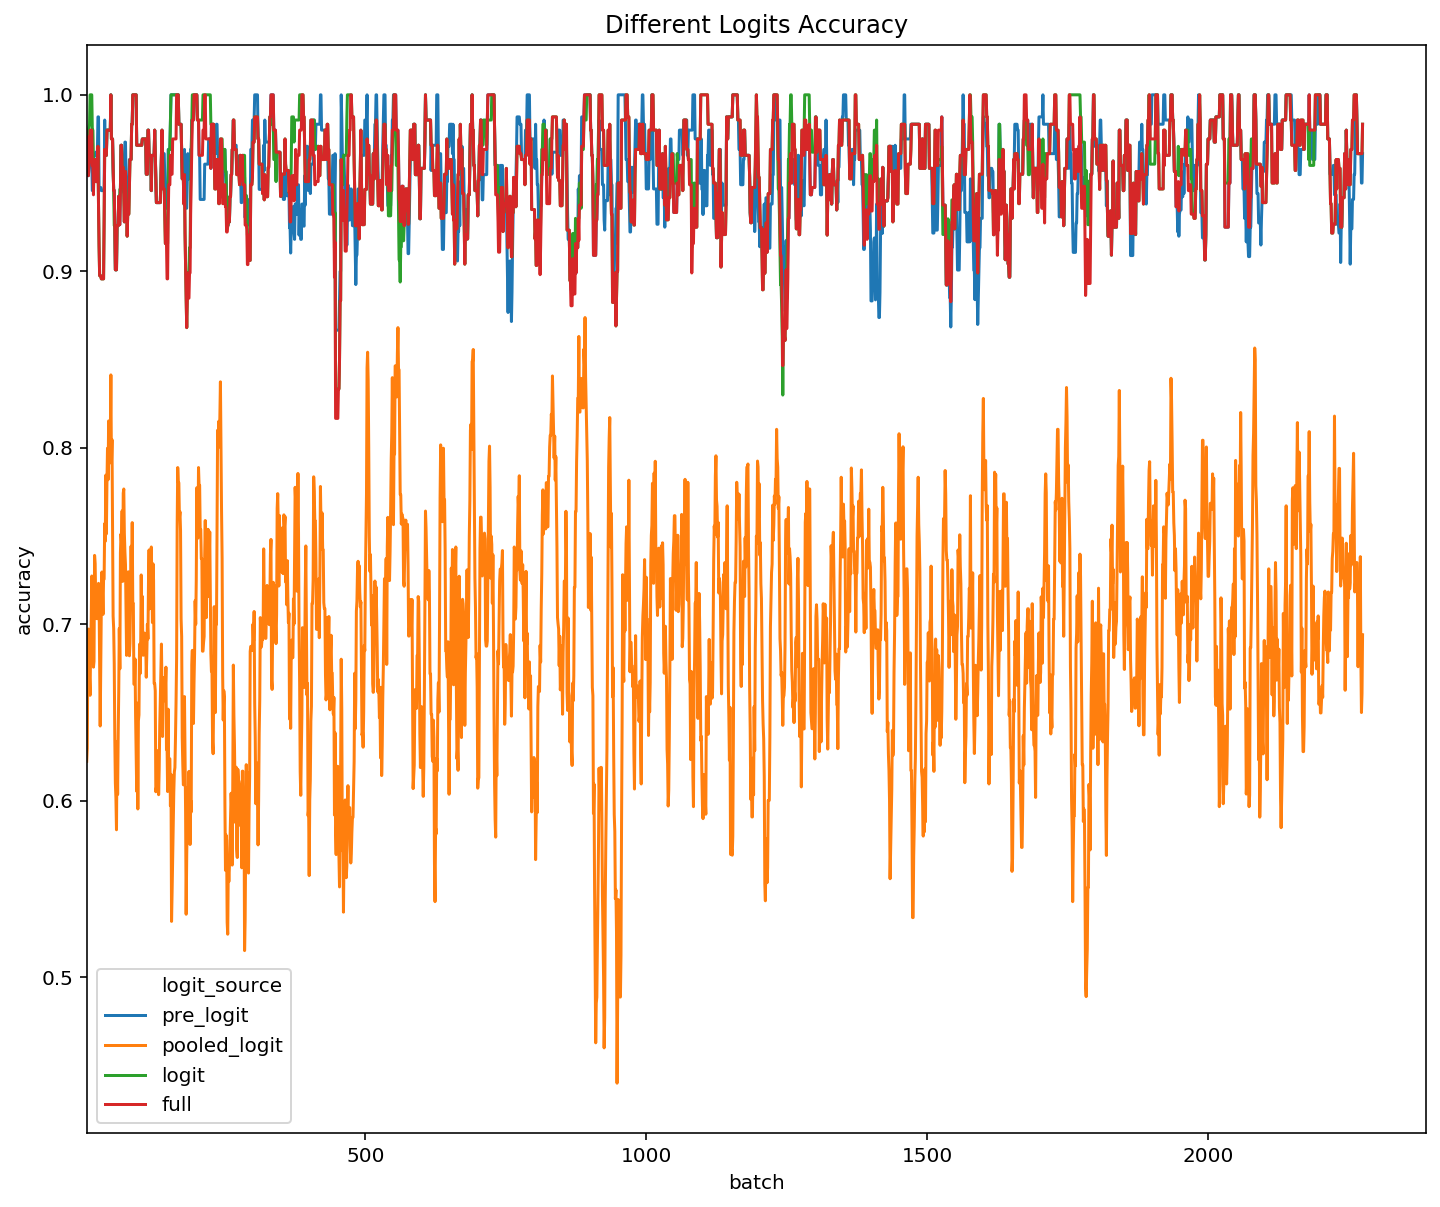

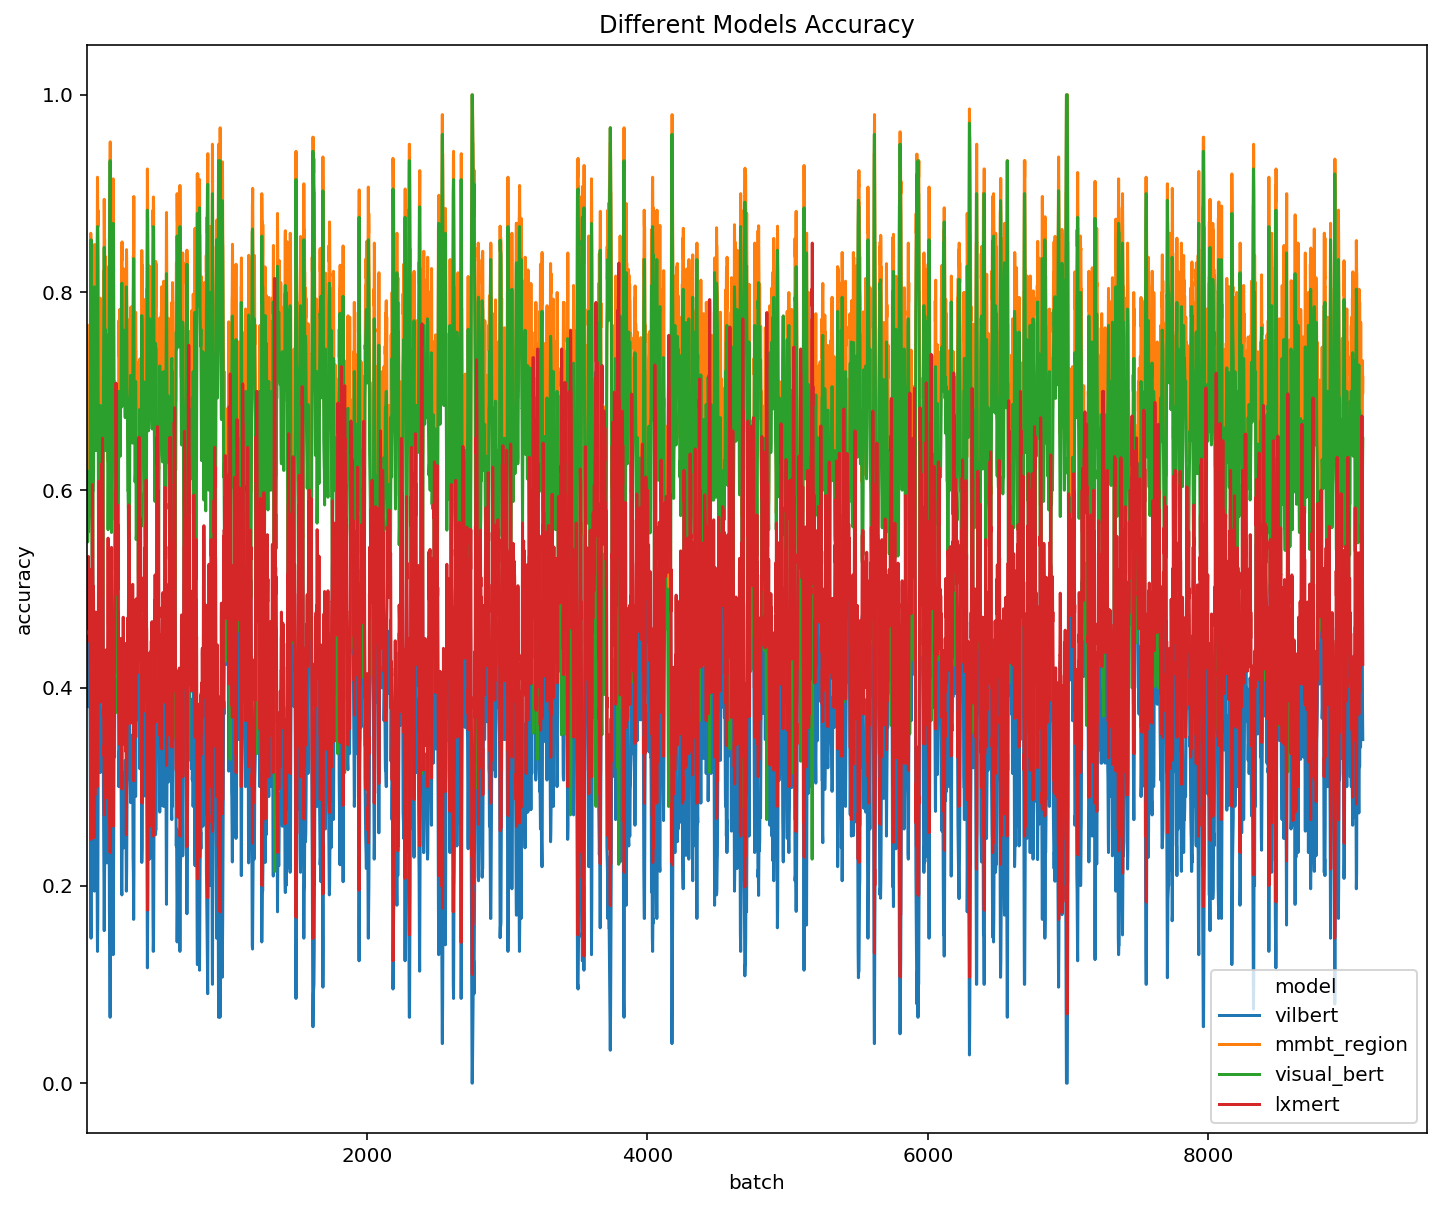

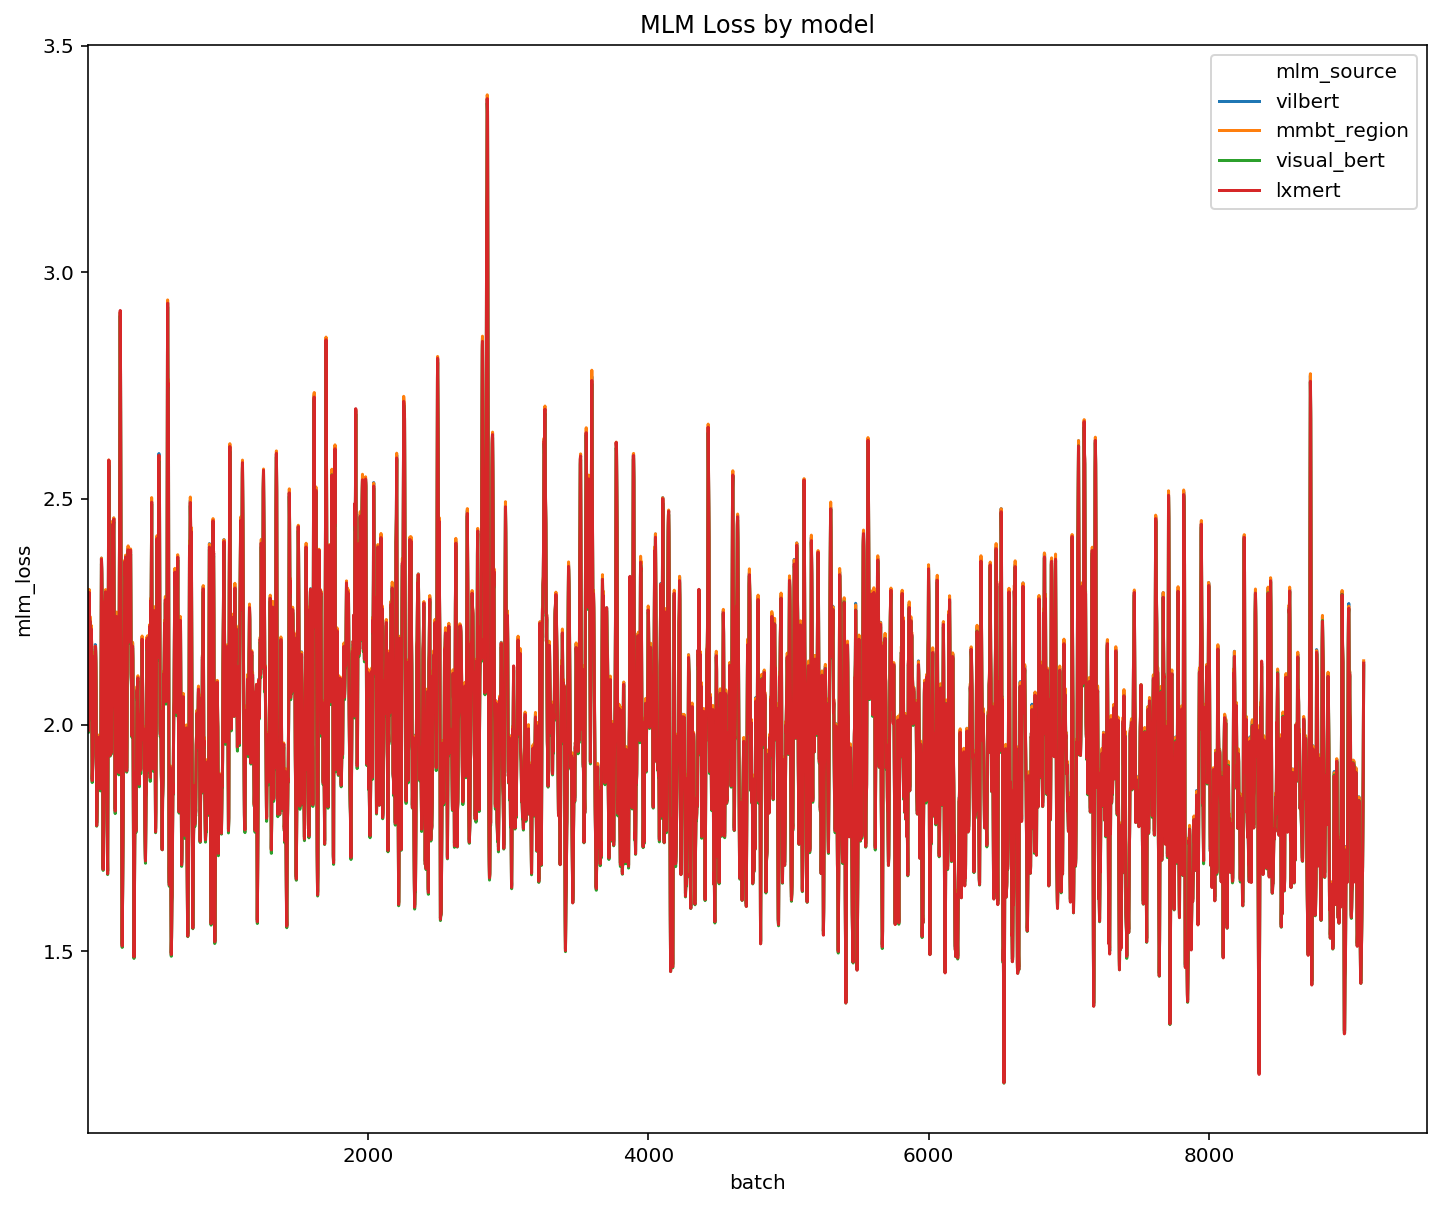

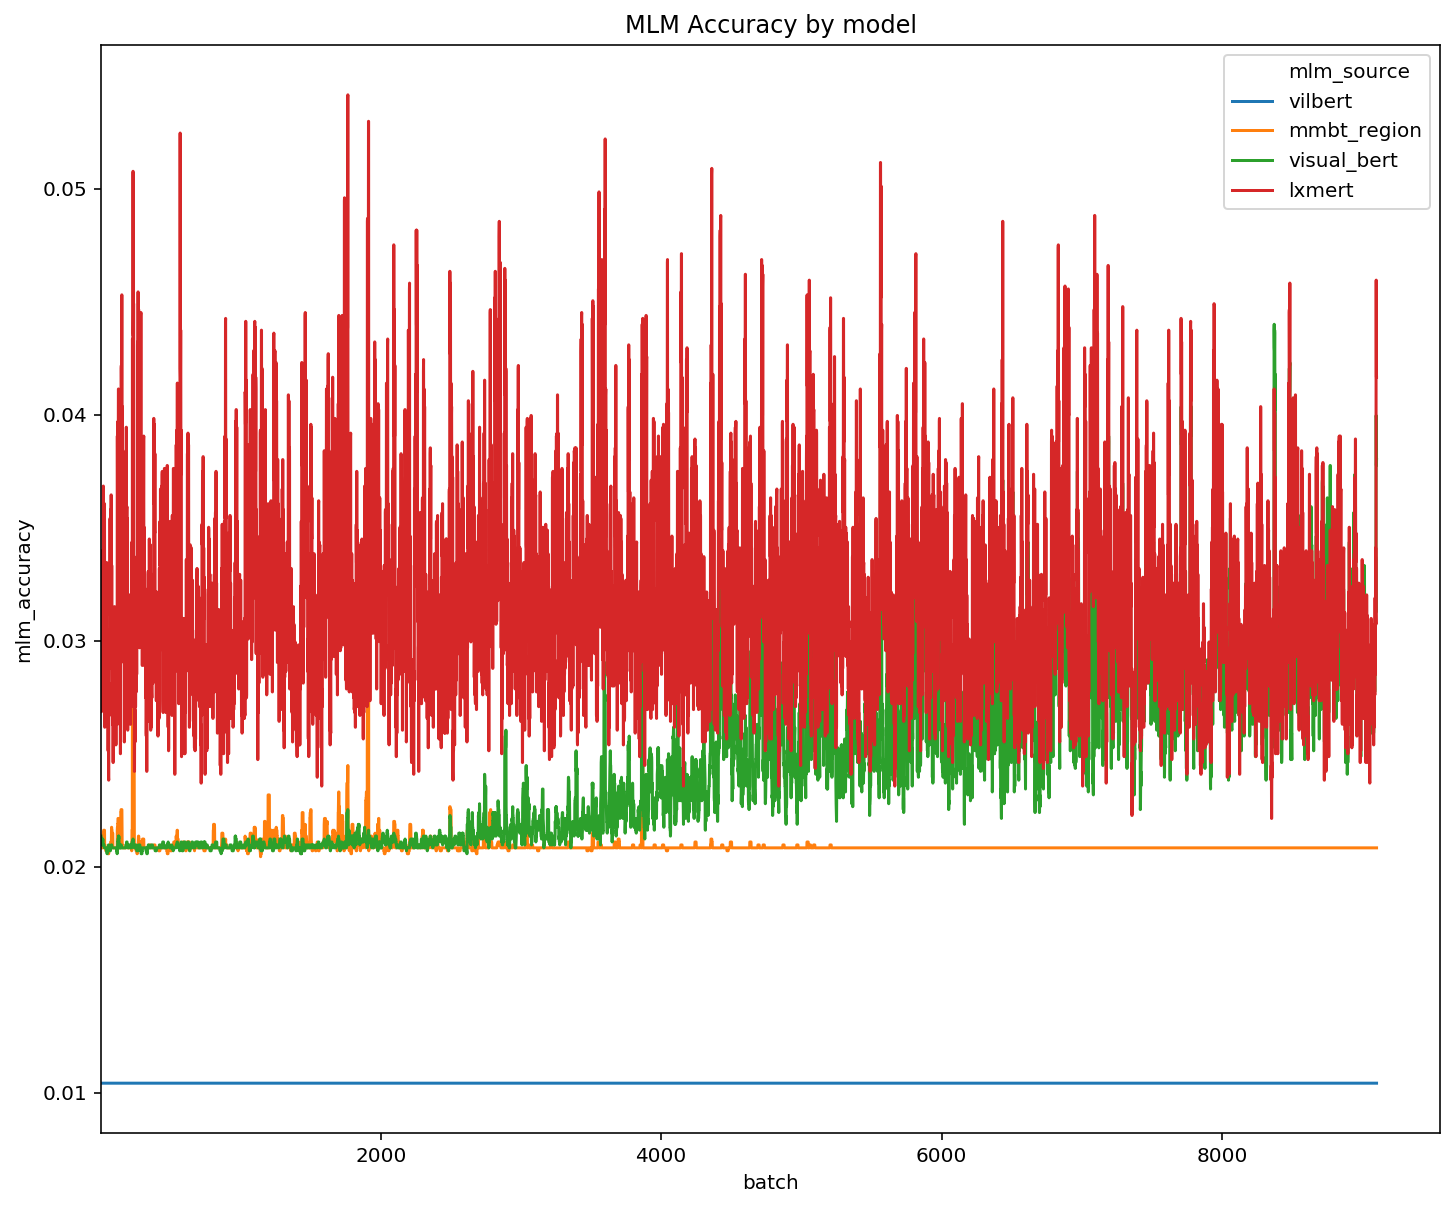

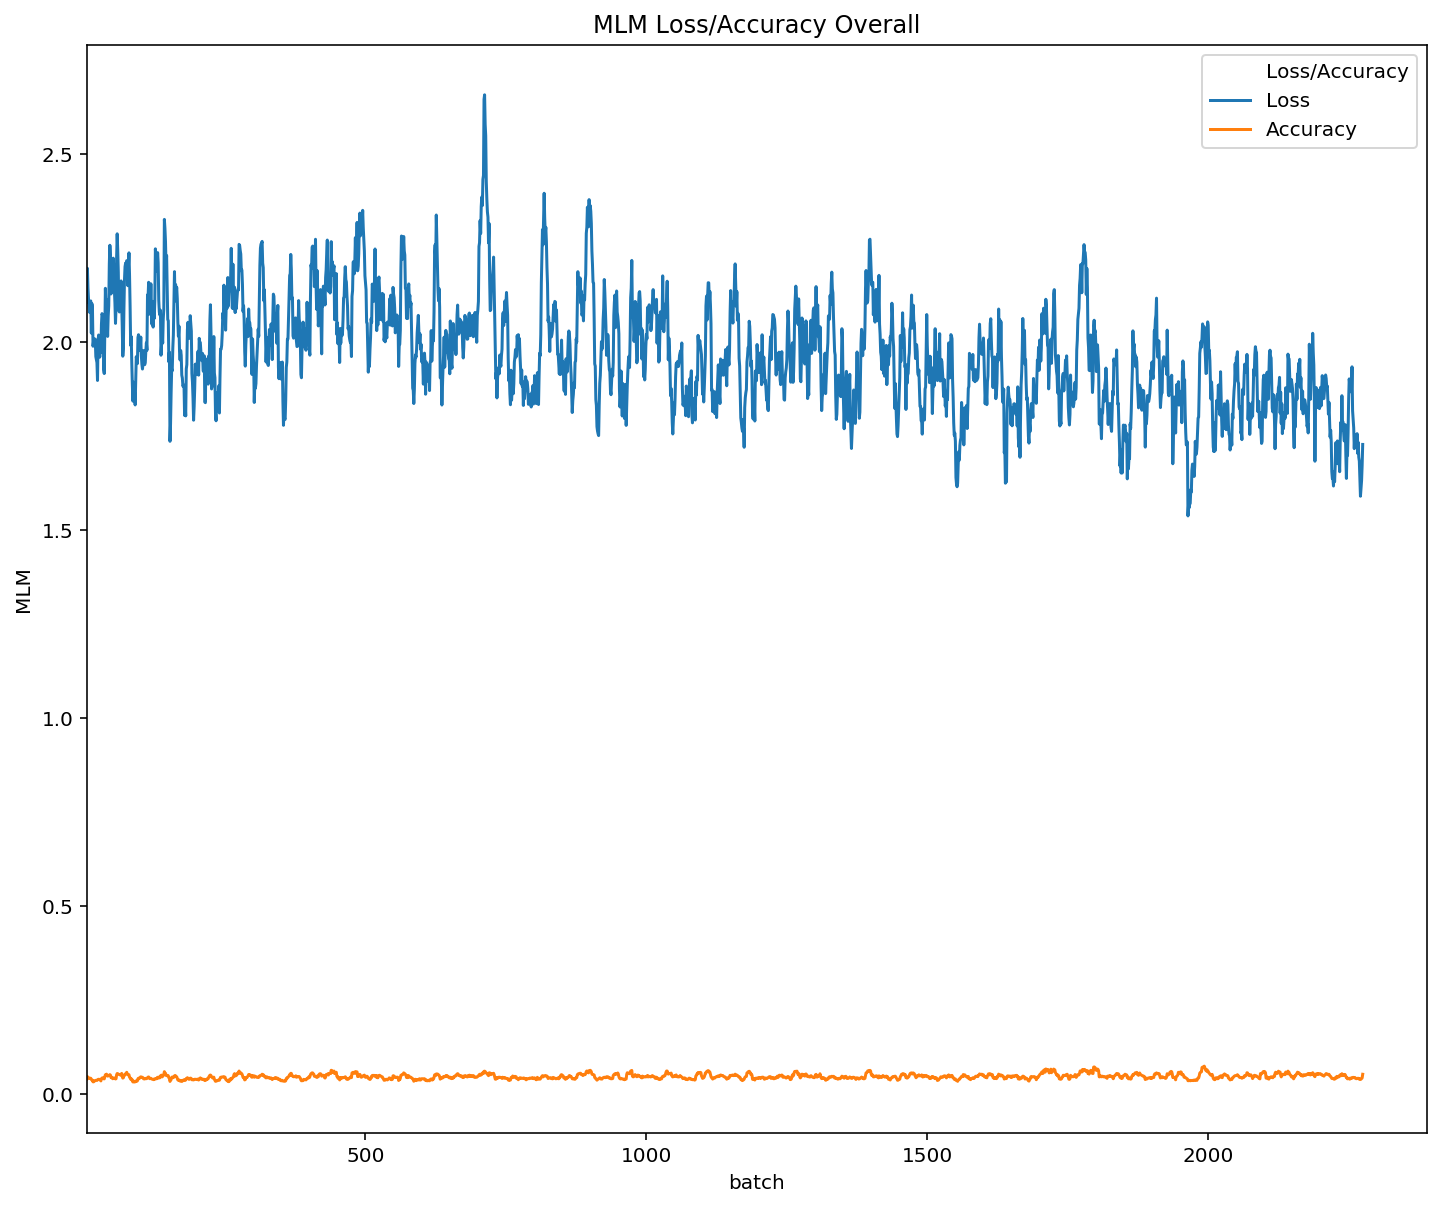

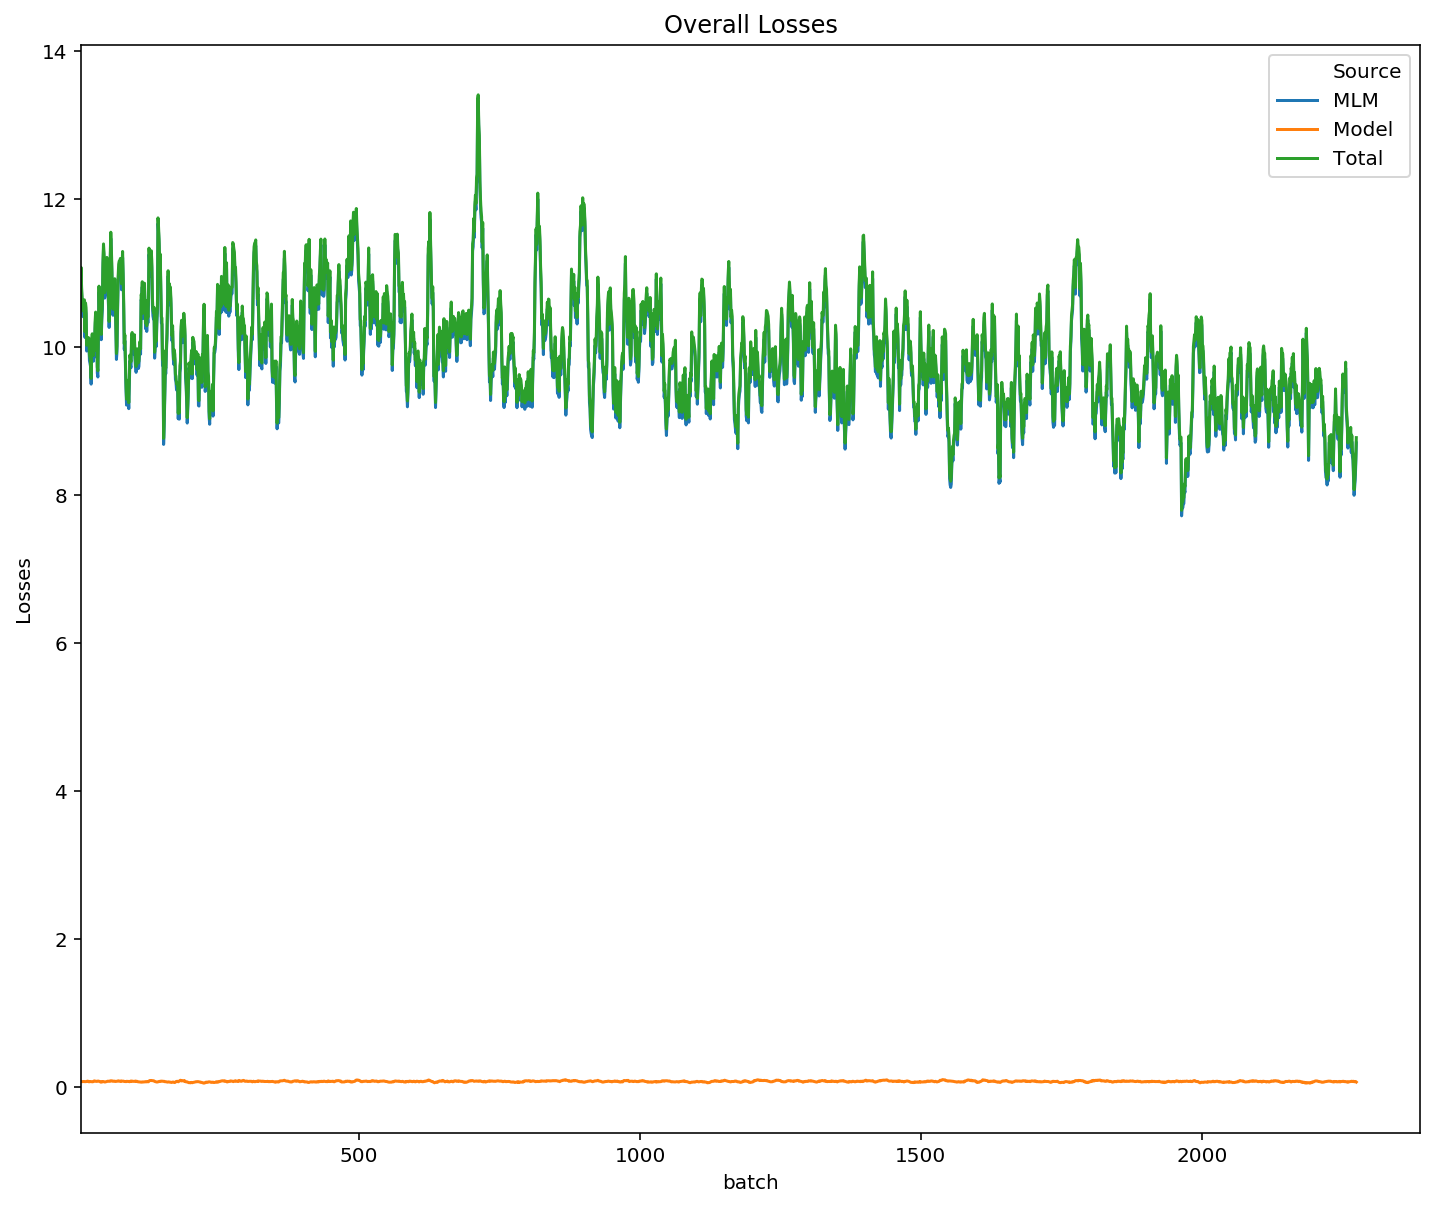

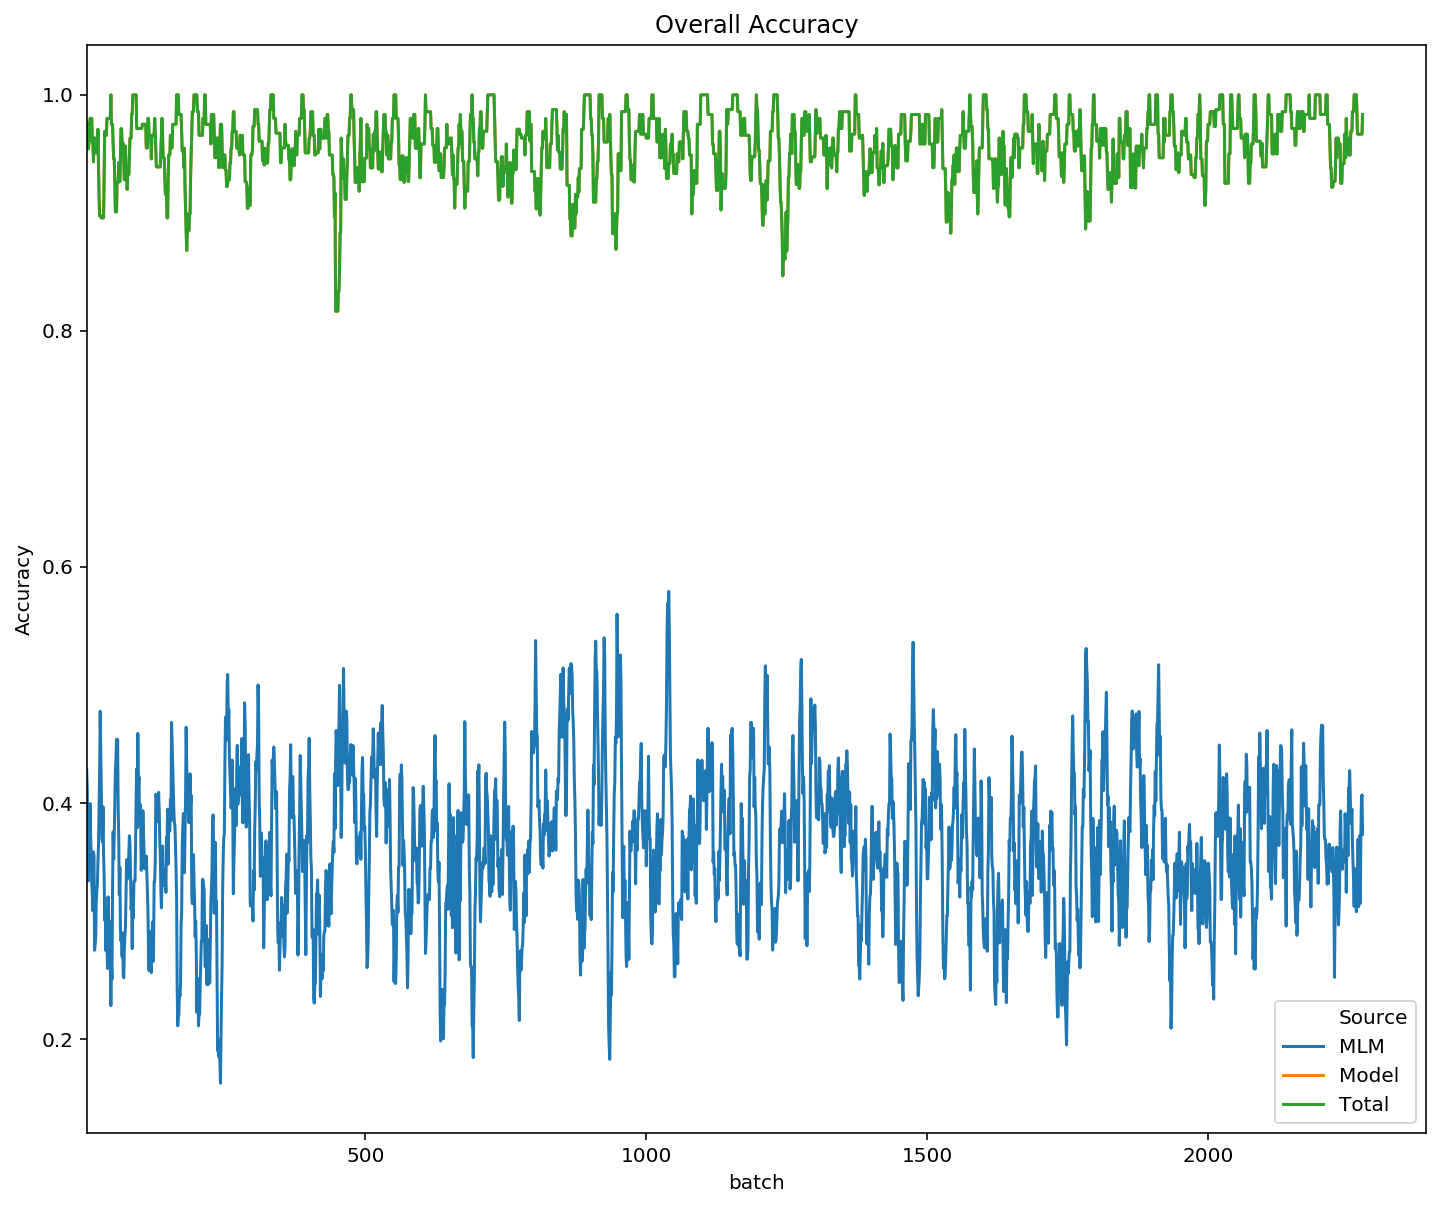

In [14]:
make_plots(model, mlm_model, logy=False, exclude_from_start=5, smoothing=10)

# Single Eval

## Validate

In [ ]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev'], data["metadata"], False, additional_processors=get_views())
validate(mlm_model, batch_size, dev_dataset, display_detail=True)


In [ ]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev'], data["metadata"], False, additional_processors=get_views())
validate(model, batch_size, dev_dataset, display_detail=True)


In [ ]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False, additional_processors=get_views())
validate(mlm_model, batch_size, dev_dataset, display_detail=True)


In [ ]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False, additional_processors=get_views())
validate(model, batch_size, dev_dataset, display_detail=True)


## Predict

In [15]:
clean_memory()
batch_size = 16
preds = predict(mlm_model, data, batch_size, competition_phase=1)


In [ ]:
preds = predict(model, data, batch_size, competition_phase=1)


In [16]:
preds.to_csv("submission_phase_1.csv", index=False)

# Multi-eval
- Use back-translation
    - Longest 3 backtranslation
- Use imgaug
    - identity
    - HFlip
    - GrayScale
    - GridDrop
    
- Use word replace
    - Replace top 2 longest word
- Use `[masking]`
    - 0.15 mask rate `5` times
- identity text
    
(5+3+3)*4 = 44
